In [1]:
'''
P2P

with normalisation
no dropout
'''

'\nP2P\n\nwith normalisation\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'drive/My Drive/Dissertation')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install git+git://github.com/nilmtk/nilmtk.git

  Cloning git://github.com/nilmtk/nilmtk.git to /tmp/pip-req-build-uix_1h7i
  Running command git clone -q git://github.com/nilmtk/nilmtk.git /tmp/pip-req-build-uix_1h7i
     |████████████████████████████████| 2.9MB 45.0MB/s 
     |████████████████████████████████| 1.6MB 54.9MB/s 
     |████████████████████████████████| 153kB 42.7MB/s 
     |████████████████████████████████| 337kB 28.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-tn9ofewt/wheels/71/84/2f/eca0fb8014a0fe59881ab1a3e3374f4108211de4c7c3081e8d
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built nilmtk networkx hmmlearn
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.9 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9

In [3]:
pip install git+git://github.com/nilmtk/nilm_metadata.git

  Cloning git://github.com/nilmtk/nilm_metadata.git to /tmp/pip-req-build-6qe_wt4v
  Running command git clone -q git://github.com/nilmtk/nilm_metadata.git /tmp/pip-req-build-6qe_wt4v
  Stored in directory: /tmp/pip-ephem-wheel-cache-ed4gczki/wheels/75/e0/6d/1ec555a322c151fe20b4c9834753a692203b1f62a66b3ee235
Successfully built nilm-metadata


In [4]:
pip install pandas==0.24.0

     |████████████████████████████████| 10.1MB 19.3MB/s 
ERROR: nilmtk 0.3.0.dev0+git.2f15ab7 has requirement pandas==0.24.2, but you'll have pandas 0.24.0 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore


import random
import sys
import pandas as pd
import numpy as np
import h5py


In [0]:
# =====Define paramaters======
info = {'filename': 'drive/My Drive/Dissertation/redd.h5',
        'meter_label': 'fridge',  # ["kettle" , "microwave" , "dishwasher" , "fridge" , "washing_machine"]
        'train_building': 1,
        'test_building': 1,
        'sample_period': 3
       }

# Parameters
params = {'batch_size': 512,
          'window_size': 50,
          'model_name': 'DAE',
          'shuffle': True}



#test_window = {1: ('30-4-2011', '5-5-2011')}
train_window = {1: (None, '30-4-2011')}
test_window = {1: ('30-4-2011', None)}


def load_dataset(train_window,test_window, filename, meter_label, train_building, test_building, **load_kwargs):
    
        #Load datasets
    train = DataSet(filename)
    test = DataSet(filename)

    test.set_window(*test_window[test_building])
    train.set_window(*train_window[test_building])
    
    x = train.buildings[train_building].elec.mains().all_meters()[0]
    x = x.power_series_all_data(**load_kwargs)
    
    y = train.buildings[train_building].elec.submeters()[meter_label]
    y = y.power_series_all_data(**load_kwargs)
    
    x.fillna(0, inplace=True)
    y.fillna(0, inplace=True)
    ix = x.index.intersection(y.index)
    x = np.array(x[ix])
    y = np.array(y[ix])
    
    #TEST
    
    x_test = test.buildings[test_building].elec.mains().all_meters()[0]
    x_test = x_test.power_series_all_data(**load_kwargs)
    
    y_test = test.buildings[test_building].elec.submeters()[meter_label]
    y_test = y_test.power_series_all_data(**load_kwargs)
    
    x_test.fillna(0, inplace=True)
    y_test.fillna(0, inplace=True)
    ix = x_test.index.intersection(y_test.index)
    x_test = np.array(x_test[ix])
    y_test = np.array(y_test[ix])

    return x ,y,x_test,y_test 
  
  
x , y, x_test, y_test =load_dataset(train_window,test_window, **info)  



### Nomralise Data

In [0]:
def normalise(data,mmax):
    return data/mmax

def inversenormalise(data,mmax):
    return data*mmax


mmax = np.max(x)
x = normalise(x,mmax)
y = normalise(y,mmax)

## Windows


In [0]:
indexer = np.arange(params['window_size'])[None, :] + np.arange(len(x)-params['window_size']+1)[:, None]
x = x[indexer]
y = y[params['window_size']-1:]

x = np.reshape(x, (x.shape[0],params['window_size'],1))
y = np.reshape(y, (y.shape[0],1))

# GRU

In [11]:
import random
import sys
import pandas as pd
import numpy as np
import h5py

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GRU, Bidirectional, Dropout


model = Sequential()

# 1D Conv
model.add(Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=(params['window_size'],1)))
model.add(Conv1D(8, 4, activation="relu", padding="same", strides=1))

# Bi-directional LSTMs
model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
model.add(Bidirectional(GRU(128, return_sequences=False, stateful=False), merge_mode='concat'))

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.fit(x, y, epochs=8, batch_size=128, shuffle=True)

Using TensorFlow backend.
W0628 13:25:03.325930 140158274418560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 13:25:03.366490 140158274418560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 13:25:03.376542 140158274418560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 13:25:04.178723 140158274418560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 13:25:04.611607 14015827

Epoch 1/8
334307/334307 [==============================] - 615s 2ms/step - loss: 1.7345e-04
Epoch 2/8
334307/334307 [==============================] - 609s 2ms/step - loss: 1.4254e-04
Epoch 3/8
334307/334307 [==============================] - 610s 2ms/step - loss: 1.3523e-04
Epoch 4/8
334307/334307 [==============================] - 611s 2ms/step - loss: 1.3309e-04
Epoch 5/8
334307/334307 [==============================] - 610s 2ms/step - loss: 1.3053e-04
Epoch 6/8
334307/334307 [==============================] - 609s 2ms/step - loss: 1.2935e-04
Epoch 7/8
334307/334307 [==============================] - 606s 2ms/step - loss: 1.2795e-04
Epoch 8/8
334307/334307 [==============================] - 615s 2ms/step - loss: 1.2703e-04


In [0]:
predict = model.predict(x, batch_size=128)


In [0]:
y = inversenormalise(y,mmax)
predict = inversenormalise(predict,mmax)

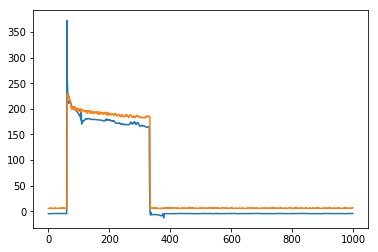

In [18]:
plt.plot(predict[65000:66000])
plt.plot(y[65000:66000])

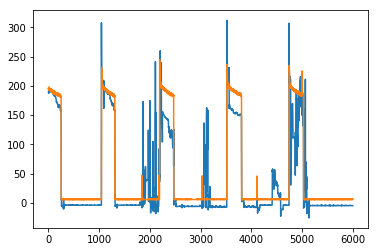

In [22]:
plt.plot(predict[52000:58000])
plt.plot(y[52000:58000])

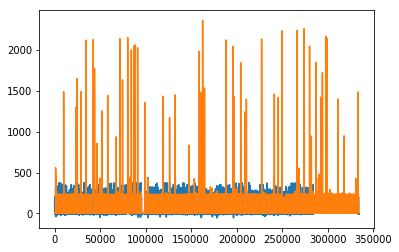

In [20]:
plt.plot(predict)
plt.plot(y)

## Test

In [0]:
mmax = np.max(x_test)
x_test = normalise(x_test,mmax)


indexer = np.arange(params['window_size'])[None, :] + np.arange(len(x)-params['window_size']+1)[:, None]
x_test = x_test[indexer]
x_test = np.reshape(x_test, (x_test.shape[0],params['window_size'],1))


In [0]:
predict = model.predict(x_test, batch_size=128)


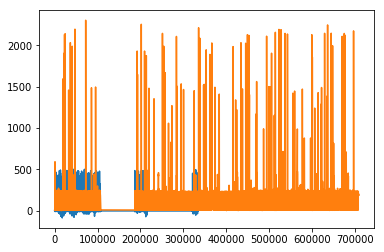

In [37]:
predict = inversenormalise(predict,mmax)
plt.plot(predict)
plt.plot(y_test)

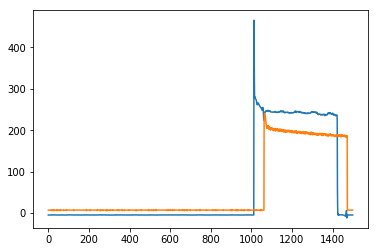

In [43]:
plt.plot(predict[1500:3000])
plt.plot(y_test[1500:3000])

## DAE

In [51]:
from keras.layers import Reshape, BatchNormalization, Activation, Flatten, Concatenate

model = Sequential()

# 1D Conv
model.add(Conv1D(30, 10, activation='relu', input_shape=(params['window_size'],1), padding="same", strides=1))
model.add(Dropout(0.3))
model.add(Conv1D(30, 8, activation='relu', padding="same", strides=1))
model.add(Dropout(0.3))
model.add(Conv1D(40, 6, activation='relu', padding="same", strides=1))
model.add(Dropout(0.3))
model.add(Conv1D(50, 5, activation='relu', padding="same", strides=1))
model.add(Dropout(0.3))
model.add(Conv1D(50, 5, activation='relu', padding="same", strides=1))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.fit(x, y, epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
334307/334307 [==============================] - 21s 62us/step - loss: 1.7693e-04
Epoch 2/20
334307/334307 [==============================] - 20s 59us/step - loss: 1.4958e-04
Epoch 3/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.4743e-04
Epoch 4/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.4829e-04
Epoch 5/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.5202e-04
Epoch 6/20
334307/334307 [==============================] - 20s 59us/step - loss: 1.4909e-04
Epoch 7/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.5579e-04
Epoch 8/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.5180e-04
Epoch 9/20
334307/334307 [==============================] - 19s 58us/step - loss: 1.5239e-04
Epoch 10/20
334307/334307 [==============================] - 20s 58us/step - loss: 1.4856e-04
Epoch 11/20
334307/334307 [==============================] - 20s 58us

In [0]:
predict = model.predict(x, batch_size=128)


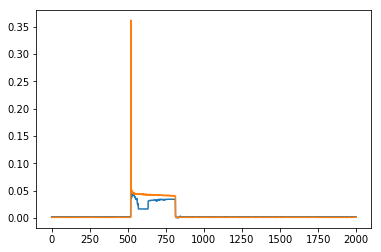

In [53]:
plt.plot(predict[74000:76000])
plt.plot(y[74000:76000])

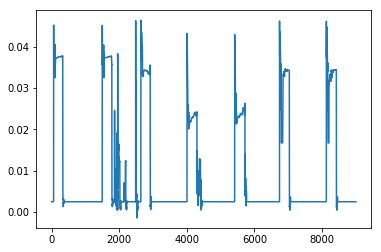

In [58]:
plt.plot(predict[65000:74000])

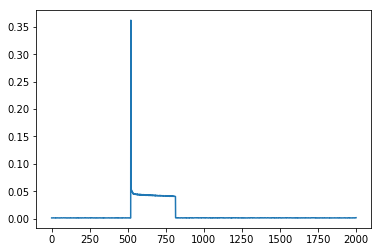

In [55]:
plt.plot(y[74000:76000])

## DresNet

In [0]:
from keras.models import load_model, Model, Input

def residual_block(filters,xin,stride = 1,dilate = None):
    resiual = xin
    out = BatchNormalization()(xin)
    out1 = Activation('relu')(out)
    out = Conv1D(filters = filters,kernel_size = [3],dilation_rate = dilate,strides = [1],padding = 'same')(out1)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv1D(filters = filters,kernel_size = [3],strides = [1],padding = 'same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv1D(filters = filters,kernel_size = [1],dilation_rate = dilate,strides = [1],padding = 'same')(out)

    if out1.shape[-1] != filters or stride == 1:
        residual = Conv1D(filters = filters,kernel_size = [3],strides = [1],padding = 'same')(out1)
        out = Concatenate()([residual,out])
    return out

xin = Input(shape = [params['window_size'],1])
conv1 = Conv1D(filters = 30,kernel_size = [5],dilation_rate = [1],strides = [1],padding = 'same')(xin)
bn = BatchNormalization()(conv1)
out = Activation('relu')(bn)
repetition = [3,4,6,3]
filter_num = [30,40,50,50]
dilations = [[1],[2],[3],[3]]
for i in range(len(repetition)):
    for j in range(repetition[i]):
        out = residual_block(filters = filter_num[i],dilate = dilations[i],xin = out)

out = Flatten()(out)
out = Dense(units = 1)(out)
model = Model(xin,out)
model.compile(optimizer = 'adam',loss = 'mse')

In [72]:
model.fit(x, y, epochs=10, batch_size=128, shuffle=True)


Epoch 1/10
334307/334307 [==============================] - 239s 714us/step - loss: 0.0022
Epoch 2/10
334307/334307 [==============================] - 237s 709us/step - loss: 5.2069e-04
Epoch 3/10
334307/334307 [==============================] - 237s 710us/step - loss: 2.8162e-04
Epoch 4/10
334307/334307 [==============================] - 238s 711us/step - loss: 0.0864
Epoch 5/10
334307/334307 [==============================] - 240s 717us/step - loss: 0.0013
Epoch 6/10
334307/334307 [==============================] - 243s 726us/step - loss: 9.3079e-04
Epoch 7/10
334307/334307 [==============================] - 237s 710us/step - loss: 3.2789e-04
Epoch 8/10
334307/334307 [==============================] - 238s 710us/step - loss: 0.0197
Epoch 9/10
334307/334307 [==============================] - 238s 713us/step - loss: 4.6354e-04
Epoch 10/10
334307/334307 [==============================] - 244s 729us/step - loss: 3.4755e-04


In [0]:
predict = model.predict(x, batch_size=128)

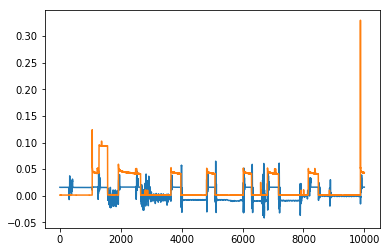

In [80]:
plt.plot(predict[0:10000])
plt.plot(y[0:10000])